In [2]:
import os
import zipfile
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from google.colab import files
import shutil
import tensorflow as tf

In [ ]:
# Check if 'archive.zip' already exists
if not os.path.exists('archive.zip'):
    print("Please upload 'archive.zip' to proceed.")
    uploaded = files.upload()  # This will prompt you to upload the file
    for filename in uploaded.keys():
        if filename != 'archive.zip':
            print(f"Warning: Uploaded file '{filename}' is not 'archive.zip'. Please ensure you upload the correct file.")
else:
    print("'archive.zip' already exists in the current directory.")

'archive.zip' already exists in the current directory.


In [ ]:
zip_file = 'archive.zip'

def verify_zip(zip_file):
    """
    Verifies if the zip file is valid and contains the 'UTKFace/' directory.
    """
    if not os.path.exists(zip_file):
        print(f"Error: '{zip_file}' does not exist in the current directory.")
        print("Available files:", os.listdir('.'))
        return False
    try:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_contents = zip_ref.namelist()
            # Check if 'UTKFace/' directory exists
            if any(name.startswith('UTKFace/') for name in zip_contents):
                print(f"'{zip_file}' is a valid zip file containing the 'UTKFace/' directory.")
                return True
            else:
                print(f"Error: '{zip_file}' does not contain the 'UTKFace/' directory.")
                print("Contents of the ZIP file:")
                for item in zip_contents:
                    print(item)
                return False
    except zipfile.BadZipFile:
        print(f"Error: '{zip_file}' is not a valid zip file or is corrupted.")
        return False

# Verify the ZIP file
is_zip_valid = verify_zip(zip_file)

# If the zip is invalid, prompt the user to re-upload
if not is_zip_valid:
    print("\nPlease ensure you upload a valid 'archive.zip' containing the 'UTKFace/' directory.")
    print("If 'archive.zip' is corrupted or incomplete, re-download it from the official source and upload again.")
    # Optionally, provide instructions to upload again
    print("\nRe-upload 'archive.zip':")
    uploaded = files.upload()
    # Re-verify after re-upload
    is_zip_valid = verify_zip(zip_file)
    if not is_zip_valid:
        raise Exception("The uploaded 'archive.zip' is still invalid. Please check the file and try again.")

'archive.zip' is a valid zip file containing the 'UTKFace/' directory.


In [ ]:
def unzip_dataset(zip_file, extract_to='.'):
    """
    Extracts the dataset zip file to the specified directory.
    """
    try:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"\nDataset '{zip_file}' extracted successfully.")
        return True
    except zipfile.BadZipFile:
        print(f"Error: '{zip_file}' is not a valid zip file or is corrupted.")
        return False

# Check if 'UTKFace/' directory already exists to avoid re-extraction
DATASET_DIR_NAME = 'UTKFace'  # Expected directory name after extraction
DATA_DIR = os.path.join('.', DATASET_DIR_NAME)

if not os.path.exists(DATA_DIR):
    extraction_success = unzip_dataset(zip_file, '.')
    if not extraction_success:
        raise FileNotFoundError(f"Failed to extract '{zip_file}'. Please ensure it's a valid ZIP archive.")
else:
    print(f"\nDataset directory '{DATASET_DIR_NAME}' already exists. Skipping extraction.")


Dataset directory 'UTKFace' already exists. Skipping extraction.


In [ ]:
print("\nDirectory structure after extraction:")
for root, dirs, files in os.walk('.'):
    level = root.replace('.', '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")

Streaming output truncated to the last 5000 lines.
            3_1_4_20161221192908158.jpg.chip.jpg
            12_1_3_20170104013517483.jpg.chip.jpg
            38_0_1_20170116200942002.jpg.chip.jpg
            2_1_2_20161219142056888.jpg.chip.jpg
            26_0_0_20170113210319024.jpg.chip.jpg
            7_0_0_20170110220552025.jpg.chip.jpg
            37_0_2_20170119193342866.jpg.chip.jpg
            35_0_0_20170117170757093.jpg.chip.jpg
            36_0_1_20170113142408744.jpg.chip.jpg
            26_1_3_20170117174556511.jpg.chip.jpg
            29_1_0_20170103181510040.jpg.chip.jpg
            21_1_1_20170112231637574.jpg.chip.jpg
            3_1_2_20161219190200060.jpg.chip.jpg
            90_1_0_20170117175312742.jpg.chip.jpg
            51_1_0_20170110154639018.jpg.chip.jpg
            43_0_4_20170104205649403.jpg.chip.jpg
            48_1_0_20170110154607979.jpg.chip.jpg
            28_0_0_20170117202521375.jpg.chip.jpg
            75_0_2_20170112224347901.jpg.chip.jpg
   

Skipping file with unexpected format: 61_1_20170109150557335.jpg.chip.jpg
Skipping file with unexpected format: 39_1_20170116174525125.jpg.chip.jpg
Skipping file with unexpected format: 24_0_1_20170116220224657 .jpg.chip.jpg
Skipping file with unexpected format: 55_0_0_20170116232725357jpg.chip.jpg
Skipping file with unexpected format: 61_1_20170109142408075.jpg.chip.jpg

Total valid images found: 23703


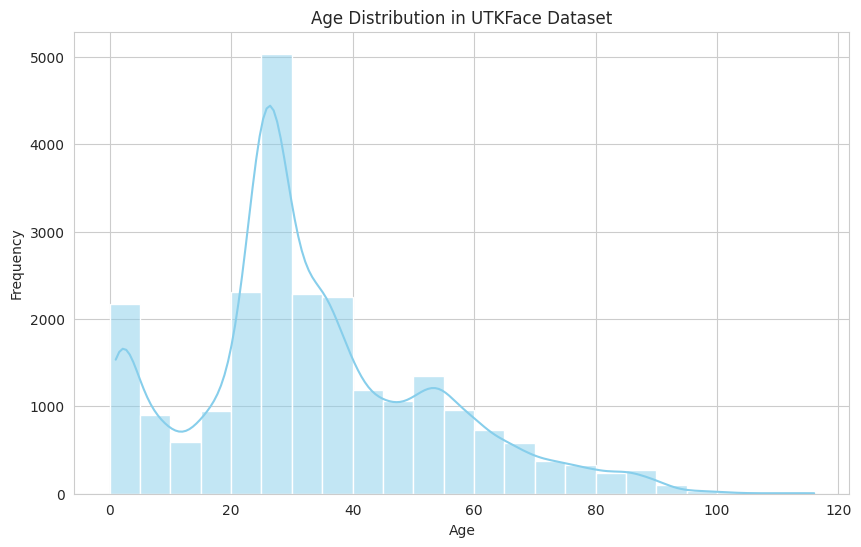

In [ ]:
# Verify that DATA_DIR exists
if not os.path.exists(DATA_DIR):
    raise FileNotFoundError(f"Data directory '{DATA_DIR}' does not exist after extraction.")

# Build a regular expression to extract age from filename
# Filename format: [age]_[gender]_[race]_[date&time].jpg
PATTERN = r'^(\d+)_(\d+)_(\d+)_(\d+)\.jpg\.chip\.jpg$'
p = re.compile(PATTERN)

# Prepare the DataFrame
data = []
for filename in os.listdir(DATA_DIR):
    if filename.endswith('.jpg'):
        match = p.match(filename)
        if match:
            age = int(match.group(1))
            gender = int(match.group(2))
            race = int(match.group(3))
            # date_time = match.group(4)  # Not used here
            data.append({'image_path': filename, 'age': age})
        else:
            print(f"Skipping file with unexpected format: {filename}")

# Create DataFrame
df = pd.DataFrame(data)
print(f"\nTotal valid images found: {len(df)}")

# Handle the case where no valid images are found
if len(df) == 0:
    raise ValueError("No valid images found in the 'UTKFace/' directory. Please check the dataset.")

# Visualize age distribution
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.histplot(df['age'], bins=range(0, 120, 5), kde=True, color='skyblue')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution in UTKFace Dataset')
plt.show()

In [ ]:


import os
import zipfile
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from google.colab import files
import shutil
import tensorflow as tf



# Check if 'archive.zip' already exists
if not os.path.exists('archive.zip'):
    print("Please upload 'archive.zip' to proceed.")
    uploaded = files.upload()  # This will prompt you to upload the file
    for filename in uploaded.keys():
        if filename != 'archive.zip':
            print(f"Warning: Uploaded file '{filename}' is not 'archive.zip'. Please ensure you upload the correct file.")
else:
    print("'archive.zip' already exists in the current directory.")



zip_file = 'archive.zip'

def verify_zip(zip_file):
    """
    Verifies if the zip file is valid and contains the 'UTKFace/' directory.
    """
    if not os.path.exists(zip_file):
        print(f"Error: '{zip_file}' does not exist in the current directory.")
        print("Available files:", os.listdir('.'))
        return False
    try:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_contents = zip_ref.namelist()
            # Check if 'UTKFace/' directory exists
            if any(name.startswith('UTKFace/') for name in zip_contents):
                print(f"'{zip_file}' is a valid zip file containing the 'UTKFace/' directory.")
                return True
            else:
                print(f"Error: '{zip_file}' does not contain the 'UTKFace/' directory.")
                print("Contents of the ZIP file:")
                for item in zip_contents:
                    print(item)
                return False
    except zipfile.BadZipFile:
        print(f"Error: '{zip_file}' is not a valid zip file or is corrupted.")
        return False

# Verify the ZIP file
is_zip_valid = verify_zip(zip_file)

# If the zip is invalid, prompt the user to re-upload
if not is_zip_valid:
    print("\nPlease ensure you upload a valid 'archive.zip' containing the 'UTKFace/' directory.")
    print("If 'archive.zip' is corrupted or incomplete, re-download it from the official source and upload again.")
    # Optionally, provide instructions to upload again
    print("\nRe-upload 'archive.zip':")
    uploaded = files.upload()
    # Re-verify after re-upload
    is_zip_valid = verify_zip(zip_file)
    if not is_zip_valid:
        raise Exception("The uploaded 'archive.zip' is still invalid. Please check the file and try again.")



def unzip_dataset(zip_file, extract_to='.'):
    """
    Extracts the dataset zip file to the specified directory.
    """
    try:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"\nDataset '{zip_file}' extracted successfully.")
        return True
    except zipfile.BadZipFile:
        print(f"Error: '{zip_file}' is not a valid zip file or is corrupted.")
        return False

# Check if 'UTKFace/' directory already exists to avoid re-extraction
DATASET_DIR_NAME = 'UTKFace'  # Expected directory name after extraction
DATA_DIR = os.path.join('.', DATASET_DIR_NAME)

if not os.path.exists(DATA_DIR):
    extraction_success = unzip_dataset(zip_file, '.')
    if not extraction_success:
        raise FileNotFoundError(f"Failed to extract '{zip_file}'. Please ensure it's a valid ZIP archive.")
else:
    print(f"\nDataset directory '{DATASET_DIR_NAME}' already exists. Skipping extraction.")



print("\nDirectory structure after extraction:")
for root, dirs, files in os.walk('.'):
    level = root.replace('.', '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")



# Verify that DATA_DIR exists
if not os.path.exists(DATA_DIR):
    raise FileNotFoundError(f"Data directory '{DATA_DIR}' does not exist after extraction.")

# Build a regular expression to extract age from filename
# Filename format: [age]_[gender]_[race]_[date&time].jpg
PATTERN = r'^(\d+)_(\d+)_(\d+)_(\d+)\.jpg$'
p = re.compile(PATTERN)

# Prepare the DataFrame
data = []
for filename in os.listdir(DATA_DIR):
    if filename.endswith('.jpg'):
        match = p.match(filename)
        if match:
            age = int(match.group(1))
            gender = int(match.group(2))
            race = int(match.group(3))
            # date_time = match.group(4)  # Not used here
            data.append({'image_path': filename, 'age': age})
        else:
            print(f"Skipping file with unexpected format: {filename}")

# Create DataFrame
df = pd.DataFrame(data)
print(f"\nTotal valid images found: {len(df)}")

# Handle the case where no valid images are found
if len(df) == 0:
    raise ValueError("No valid images found in the 'UTKFace/' directory. Please check the dataset.")

# Visualize age distribution
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.histplot(df['age'], bins=range(0, 120, 5), kde=True, color='skyblue')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution in UTKFace Dataset')
plt.show()


# Initialize ImageDataGenerator with data augmentation for training and only rescaling for validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% for validation
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=DATA_DIR,
    x_col='image_path',
    y_col='age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training',
    seed=42
)

# Create validation generator
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=DATA_DIR,
    x_col='image_path',
    y_col='age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',  # Regression
    subset='validation',
    seed=42
)


# Load the ResNet50 model without the top layers and with pretrained ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = Dropout(0.2)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='relu')(x)  # 'relu' ensures age predictions are non-negative

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with Mean Absolute Error loss and metrics
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='mae',
              metrics=['mae', 'mse'])

# Display the model summary
print("\nModel Summary:")
model.summary()



# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# Train the model for 20 epochs
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)



# Unfreeze the top 10 layers of the base model
for layer in base_model.layers[-10:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='mae',
              metrics=['mae', 'mse'])

print("\nStarting fine-tuning...")

# Continue training (fine-tuning) for additional epochs (e.g., 20 epochs)
history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=1,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)



# Evaluate the model on the validation set
val_loss, val_mae, val_mse = model.evaluate(validation_generator, verbose=0)
print(f"\nValidation MAE: {val_mae:.2f}")
print(f"Validation MSE: {val_mse:.2f}")

# Predict ages on the validation set
validation_generator.reset()  # Reset generator before prediction
predictions = model.predict(validation_generator, verbose=1)
predicted_ages = predictions.flatten()
true_ages = validation_generator.labels  # True ages

# Calculate overall MAE and MSE
overall_mae = mean_absolute_error(true_ages, predicted_ages)
overall_mse = mean_squared_error(true_ages, predicted_ages)
print(f"\nOverall MAE on Validation Set: {overall_mae:.2f}")
print(f"Overall MSE on Validation Set: {overall_mse:.2f}")

# Plot True Age vs. Predicted Age
plt.figure(figsize=(8, 8))
sns.scatterplot(x=true_ages, y=predicted_ages, alpha=0.5, color='b')
plt.plot([true_ages.min(), true_ages.max()], [true_ages.min(), true_ages.max()], 'r--')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title('True Age vs. Predicted Age')
plt.show()

# Plot Training and Validation Loss (MAE and MSE)
def plot_training_history(history, history_fine=None):
    """
    Plots the training and validation MAE and MSE over epochs.
    """
    plt.figure(figsize=(14, 6))

    # Plot MAE
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    if history_fine:
        plt.plot(history_fine.history['mae'], label='Fine-Tune Train MAE')
        plt.plot(history_fine.history['val_mae'], label='Fine-Tune Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.title('Training and Validation MAE')
    plt.legend()

    # Plot MSE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mse'], label='Train MSE')
    plt.plot(history.history['val_mse'], label='Validation MSE')
    if history_fine:
        plt.plot(history_fine.history['mse'], label='Fine-Tune Train MSE')
        plt.plot(history_fine.history['val_mse'], label='Fine-Tune Validation MSE')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.title('Training and Validation MSE')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history, history_fine)


# Save the trained model to a file
MODEL_SAVE_PATH = 'age_prediction_resnet50.h5'
model.save(MODEL_SAVE_PATH)
print(f"\nModel saved to '{MODEL_SAVE_PATH}'.")


# Load the saved model
loaded_model = load_model(MODEL_SAVE_PATH)
print(f"\nModel loaded from '{MODEL_SAVE_PATH}'.")

# Function to load and preprocess a single image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0  # Rescale
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Select sample indices from the validation set
sample_indices = [0, 10, 20, 30, 40]  # Example indices; adjust as needed

for idx in sample_indices:
    if idx >= len(validation_generator.filenames):
        print(f"Index {idx} is out of range for the validation set.")
        continue
    sample_image_path = os.path.join(DATA_DIR, validation_generator.filenames[idx])
    true_age_sample = validation_generator.labels[idx]

    # Load and preprocess the image
    sample_image = load_and_preprocess_image(sample_image_path)

    # Make a prediction
    predicted_age_sample = loaded_model.predict(sample_image)[0][0]

    # Display the image with true and predicted ages
    plt.figure(figsize=(4, 4))
    plt.imshow(image.load_img(sample_image_path))
    plt.title(f"True Age: {true_age_sample} | Predicted Age: {predicted_age_sample:.2f}")
    plt.axis('off')
    plt.show()

    print(f"Sample Image: {validation_generator.filenames[idx]}")
    print(f"True Age: {true_age_sample}")
    print(f"Predicted Age: {predicted_age_sample:.2f}\n")
